In [1]:
!pip install gymnasium numpy matplotlib tqdm

In [2]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.1 MB/s eta 0:00:00


In [3]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399013 sha256=dd6f514093eb156b7fe53a31ef523148c018a7c38a3f6a5193d70ca99f5023f7
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [4]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.9 MB/s eta 0:00:00


In [5]:
import torch as th
from torch.nn import functional as F
import numpy as np
from stable_baselines3.dqn import DQN


class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []

        for _ in range(gradient_steps):
            # Sample from replay buffer
            replay_data = self.replay_buffer.sample(
                batch_size,
                env=self._vec_normalize_env
            )

            # replay_data has:
            #   observations, actions, next_observations, dones,
            #   rewards, timeouts

            # Compute target Q-values with Double DQN logic
            # (decouple action selection & target evaluation)
            with th.no_grad():
                # Q(s', ·) from target network
                next_q_values_target = self.q_net_target(replay_data.next_observations)
                # Q(s', ·) from online network
                next_q_values_online = self.q_net(replay_data.next_observations)

                # Online network selects action: a* = argmax_a Q_online(s', a)
                next_actions_online = next_q_values_online.argmax(dim=1, keepdim=True)

                # Target network evaluates the selected action:
                # Q_target(s', a*)
                next_q_values = th.gather(
                    next_q_values_target,
                    dim=1,
                    index=next_actions_online
                )

                # Handle terminal transitions:
                # If handle_timeout_termination=True, timeouts are treated as non-terminal
                dones = replay_data.dones

                # 1-step TD target:
                # y = r + gamma * (1 - done) * Q_target(s', a*)
                target_q_values = replay_data.rewards + \
                    (1.0 - dones) * self.gamma * next_q_values

            # Current Q(s, ·) from online/behavior network
            current_q_values = self.q_net(replay_data.observations)

            # Select Q(s, a) for the actions actually taken
            # replay_data.actions has shape (batch_size, 1)
            current_q_values = th.gather(
                current_q_values,
                dim=1,
                index=replay_data.actions.long()
            )

            # Sanity check
            assert current_q_values.shape == target_q_values.shape

            # Compute TD loss (Huber)
            loss = F.smooth_l1_loss(current_q_values, target_q_values)

            losses.append(loss.item())

            # Gradient step
            self.policy.optimizer.zero_grad()
            loss.backward()
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
import os
import gymnasium as gym
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

log_dir = "./ddqn_carracing_discrete_logs/"
os.makedirs(log_dir, exist_ok=True)

def make_env():
    # Discrete version for DQN/DDQN
    env = gym.make(
        "CarRacing-v3",
        render_mode=None,   # faster (no frames)
        continuous=False    # discrete action space
    )
    # Monitor will write a .monitor.csv file in log_dir
    env = Monitor(env, os.path.join(log_dir, "carracing"))
    return env

vec_env = DummyVecEnv([make_env])

tensorboard_log = "./ddqn_carracing_discrete_tb/"

double_q_car = DoubleDQN(
    policy="CnnPolicy",
    env=vec_env,
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=10_000,
    learning_starts=10_000,
    buffer_size=100_000,
    batch_size=32,
    learning_rate=1e-4,
    policy_kwargs=dict(net_arch=[256, 256]),
    tensorboard_log=tensorboard_log,
    seed=42,
)

# Train
double_q_car.learn(total_timesteps=int(25000), log_interval=100)
double_q_car.save("double_dqn_carracing_v3_discrete")

/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Using cuda device
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging to ./ddqn_carracing_discrete_tb/DQN_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


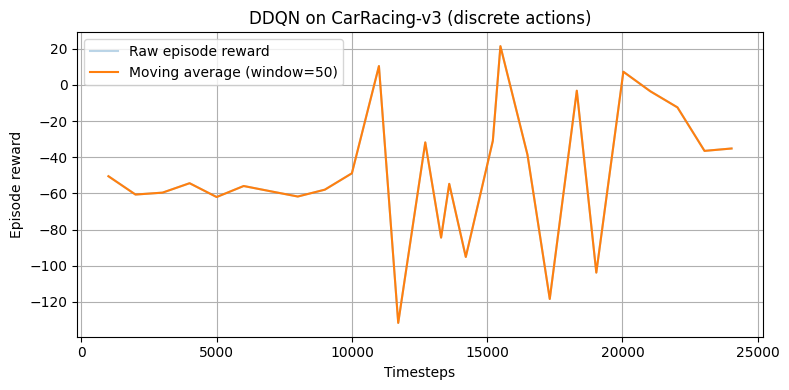

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import load_results, ts2xy
import numpy as np

def moving_average(values, window):
    if len(values) < window:
        return values
    return np.convolve(values, np.ones(window) / window, mode="valid")

def plot_learning_curve(log_folder, window=50):
    results = load_results(log_folder)
    x, y = ts2xy(results, "timesteps")  # x: timesteps, y: episode rewards

    y_ma = moving_average(y, window=window)
    x_ma = x[len(x) - len(y_ma):]  # align lengths

    plt.figure(figsize=(8, 4))
    plt.plot(x, y, alpha=0.3, label="Raw episode reward")
    plt.plot(x_ma, y_ma, label=f"Moving average (window={window})")
    plt.xlabel("Timesteps")
    plt.ylabel("Episode reward")
    plt.title("DDQN on CarRacing-v3 (discrete actions)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curve(log_dir, window=50)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy

# Reload
# from stable_baselines3.dqn import DoubleDQN subclass
# double_q_car = DoubleDQN.load("double_dqn_carracing_v3_discrete", env=vec_env)

mean_reward, std_reward = evaluate_policy(
    double_q_car,
    vec_env,
    n_eval_episodes=10,
    deterministic=True,
    render=False,
)
print(f"Eval over 10 episodes → mean reward = {mean_reward:.2f} ± {std_reward:.2f}")

Eval over 10 episodes → mean reward = -5.90 ± 38.16


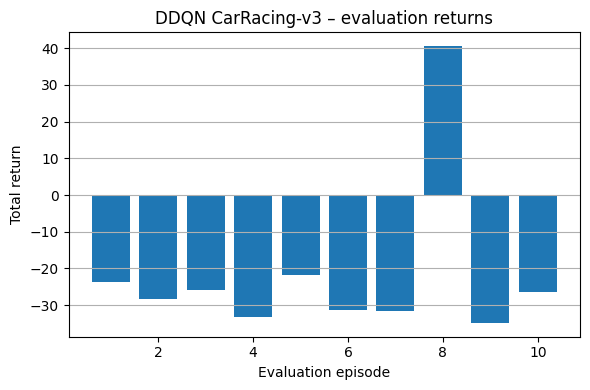

Episode returns: [-23.636365920305252, -28.32764771580696, -25.795053511857986, -33.121018916368484, -21.933085948228836, -31.372552186250687, -31.50685227662325, 40.5750797316432, -34.85341990739107, -26.315789729356766]
Mean: -21.63 | Std: 21.11


In [9]:
def eval_episode_returns(model, env, n_episodes=10):
    episode_returns = []
    for _ in range(n_episodes):
        obs = env.reset()          # VecEnv: no (obs, info), just obs
        done = False
        ep_return = 0.0

        while not done:
            # obs shape: (n_envs, *obs_shape)
            action, _ = model.predict(obs, deterministic=True)
            # step returns: obs, rewards, dones, infos
            obs, rewards, dones, infos = env.step(action)

            # Because num_envs=1, index at 0
            ep_return += float(rewards[0])
            done = bool(dones[0])

        episode_returns.append(ep_return)

    return episode_returns

episode_returns = eval_episode_returns(double_q_car, vec_env, n_episodes=10)

plt.figure(figsize=(6, 4))
plt.bar(range(1, len(episode_returns) + 1), episode_returns)
plt.xlabel("Evaluation episode")
plt.ylabel("Total return")
plt.title("DDQN CarRacing-v3 – evaluation returns")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

print("Episode returns:", episode_returns)
print(f"Mean: {np.mean(episode_returns):.2f} | Std: {np.std(episode_returns):.2f}")

In [10]:
import gymnasium as gym
import numpy as np
import imageio
from IPython.display import Video

def record_ddqn_carracing_video(model, video_path="ddqn_carracing_run.mp4",
                                max_steps=1000, seed=42):
    # Create env with video rendering
    env = gym.make(
        "CarRacing-v3",
        render_mode="rgb_array_list",  # env.render() returns list of frames
        continuous=False               # discrete action space version
    )

    obs, info = env.reset(seed=seed)
    frames = []
    total_reward = 0.0

    for t in range(max_steps):
        # Model predicts a discrete action
        action, _ = model.predict(obs, deterministic=True)

        # Step
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        # Collect all frames rendered since last call
        frames.extend(env.render())

        if terminated or truncated:
            print(f"Episode finished at step {t}, total reward = {total_reward:.2f}")
            break

    env.close()

    # Save to MP4
    if len(frames) == 0:
        print("No frames captured – check render_mode or environment setup.")
        return

    imageio.mimsave(video_path, frames, fps=30)
    print(f"Video saved to: {video_path}")

    # If in a notebook, show inline
    return Video(video_path, embed=True)

In [11]:
video = record_ddqn_carracing_video(double_q_car, "ddqn_carracing_run.mp4")
video  # Jupyter will display this

Episode finished at step 999, total reward = 37.81


Video saved to: ddqn_carracing_run.mp4
